In [1]:
import cupy as cp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pickle
import sys


sys.path.append(os.path.join(os.getenv("HOME"), "gpuaffman_networks/"))
import general_network_visualization
from genetics import analysis_util, tasks

In [2]:
plt_save_dir = "/home/trevor/boolean_network_data/plots_and_misc_material"

In [3]:
data_path = "boolean_network_data/xor_evolution_results/2023-02-21-12-42-43/batch_1.npz"
data = np.load(os.path.join(os.getenv("DATA_DIR"), data_path))
N = data["N"]
input_state = tasks.make_2_bit_input_state(N)
best_functions = np.expand_dims(data["functions"], 1)
best_conn = np.expand_dims(data["connectivity"], 1)
best_used_conn = np.expand_dims(data["used_connectivity"], 1)
batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_state, 1), 1),
                                      (input_state.shape[0], np.shape(best_functions)[0], 1, N)).astype(np.bool_)

In [5]:
best_functions, best_conn, best_used_conn, sorted_perfs, _ =  analysis_util.sort_by_performance(cp.array(batched_input_state), cp.array(best_functions), cp.array(best_conn), cp.array(best_used_conn), tasks.evaluate_xor_task, n_trajectories=1000)

In [6]:
import importlib
importlib.reload(general_network_visualization)
graphs = [general_network_visualization.influence_graph_from_ragged_spec(f[0, :, :], c[0, :, :], uc[0, :, :]) for f, c, uc in zip(cp.asnumpy(best_functions), cp.asnumpy(best_conn), cp.asnumpy(best_used_conn))]
[g.remove_nodes_from(list(nx.isolates(g))) for g in graphs]
[general_network_visualization.prune_non_participating(g, [0, 1, 2, 3, 4]) for  g in graphs]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

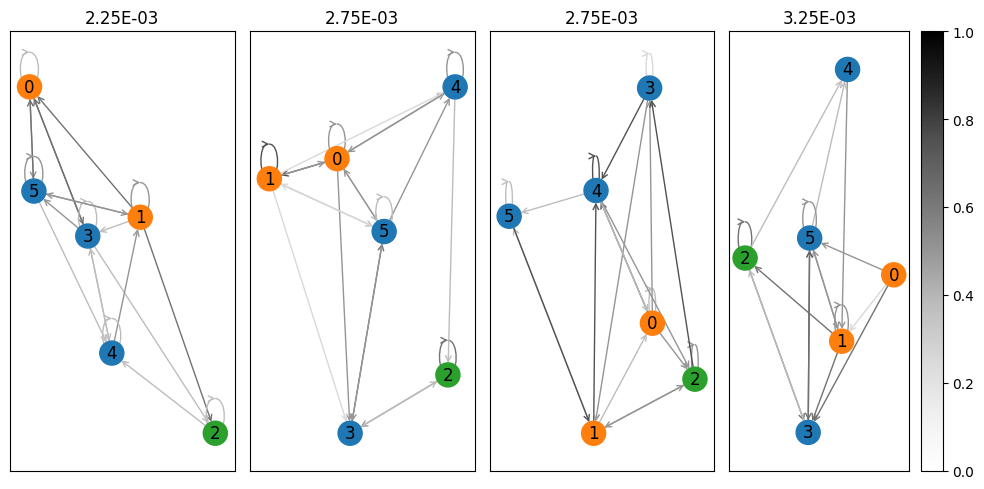

In [39]:
import importlib
importlib.reload(general_network_visualization)
best_to_plot = 4
to_plot = graphs[:best_to_plot]
fig, axs = plt.subplots(ncols=len(to_plot), figsize=(10,5))
node_colors = ["C0"] * int(N)
node_colors[0] = "C1"
node_colors[1] = "C1"
node_colors[2] = "C2"


for i, (g, ax, err) in enumerate(zip(graphs, axs, sorted_perfs[:best_to_plot])):
    pos = nx.spring_layout(g, iterations=35)
    colorbar = True if i==best_to_plot-1 else False
    general_network_visualization.plot_network_directed(g, pos, ax, node_colors[:len(g.nodes)], colorbar=colorbar)
    ax.set_title("{:.2E}".format(err))
fig.tight_layout()
plt.savefig(os.path.join(plt_save_dir, "xor_organisms.png"), dpi=400)

In [18]:
influence = analysis_util.compute_influence(best_functions[:2, 0, ...])

In [34]:
example_trajs, example_noise = analysis_util.run_dynamics_forward_save_state(cp.array(batched_input_state), best_functions, best_conn, best_used_conn, 20, 0.02)
example_trajs = np.squeeze(example_trajs, -2)
example_noise = np.squeeze(example_noise, -2)
example_trajs = cp.asnumpy(example_trajs)
example_noise = cp.asnumpy(example_noise)

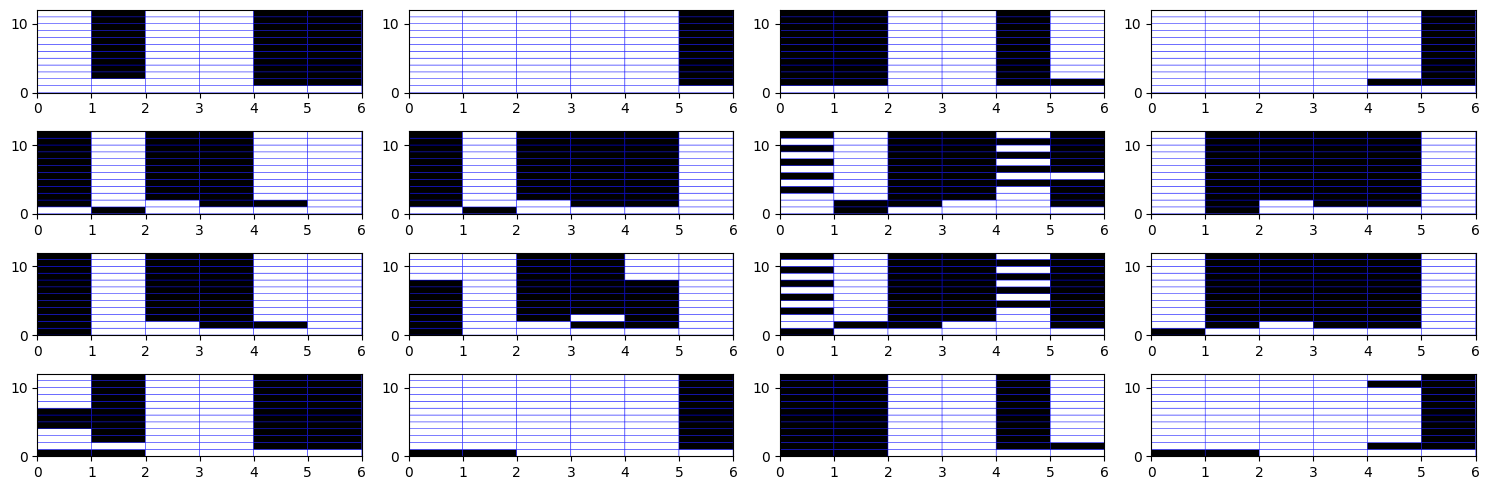

In [30]:
to_plot = list(range(4))
fig, axs = plt.subplots(nrows=len(to_plot), ncols=best_to_plot, figsize=(15, 5))
for i in range(best_to_plot):
    for j, k in enumerate(to_plot):
        axs[j, i].pcolor(example_trajs[:, k, i, :], cmap="Greys", linewidth=0.3, edgecolors="blue")
fig.tight_layout()

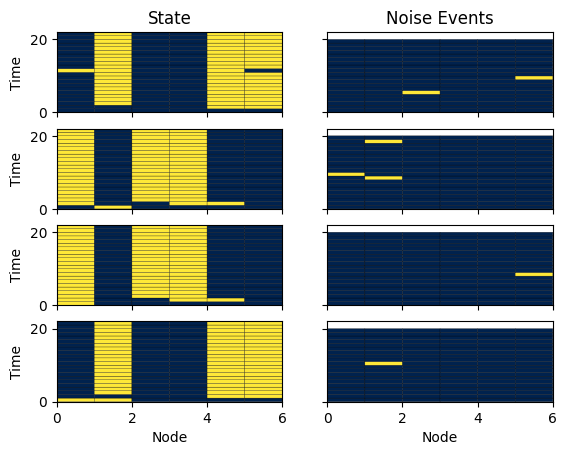

In [36]:
fig.tight_layout()
fig, axs = plt.subplots(nrows=4, ncols=2, sharey=True, sharex=True)
lw = 0.2
cm = "cividis"
axs[0, 0].pcolor(example_trajs[:, 0, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[1, 0].pcolor(example_trajs[:, 1, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[2, 0].pcolor(example_trajs[:, 2, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[3, 0].pcolor(example_trajs[:, 3, 0, :], cmap=cm, linewidth=lw, edgecolors="black")

axs[0, 1].pcolor(example_noise[:, 0, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[1, 1].pcolor(example_noise[:, 1, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[2, 1].pcolor(example_noise[:, 2, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[3, 1].pcolor(example_noise[:, 3, 0, :], cmap=cm, linewidth=lw, edgecolors="black")

axs[0, 0].set_title("State")
axs[0, 1].set_title("Noise Events")
axs[-1, 0].set_xlabel('Node')
axs[-1, 1].set_xlabel('Node')

[axs[i, 0].set_ylabel('Time') for i in range(4)]

plt.savefig(os.path.join(plt_save_dir, "xor_traj.png"), dpi=400)

In [37]:
physical_error_rates = np.linspace(start=0, stop=0.01, num=20)
logical_error_rates = analysis_util.generate_ft_curve(physical_error_rates, cp.array(batched_input_state), best_functions, best_conn, best_used_conn, tasks.evaluate_xor_task, n_traj=10000)

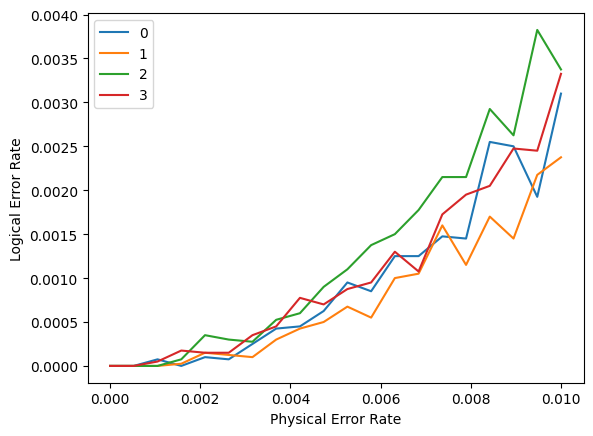

In [38]:
fig, axs = plt.subplots()
logical_error_rates = cp.asnumpy(logical_error_rates)
for j in range(best_to_plot):
    axs.plot(physical_error_rates, logical_error_rates[:, j], label="{}".format(j))
axs.set_xlabel("Physical Error Rate")
axs.set_ylabel("Logical Error Rate")
axs.legend()
plt.savefig(os.path.join(plt_save_dir, "xor_ft.png"), dpi=400)

<Figure size 640x480 with 0 Axes>